# 쇼핑몰 추천시스템(아이스탁몰)



                                                                                         캡스톤 디자인 201804255 함도윤

# 1-필요한 라이브러리 설치


In [ ]:
!pip install mlxtend
!pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline
rc('font', family='AppleGothic')

# 2-데이터 가져오기

In [ ]:
# 데이터 읽어들이기
df = pd.read_excel("/content/drive/MyDrive/캡스톤 디자인/customer_data.xlsx")
df.head()

,주문번호,아이디,회원등급,성별,나이,회원가입일,브랜드,상품명,총판매가격,제품구매가격,주문일,주소
0,A22244002*****,hwa***,VVIP,여성,55,2016-06-16 09:32:15.860,아날도바시니,(아날도바시니) 리본타이 쉬폰 나염블라우스(AT03BL01M),53570,31000,2022-09-01 00:06:04.980,경남 진주시 초전동**********
1,A22244002*****,hwa***,VVIP,여성,55,2016-06-16 09:32:15.860,예쎄,(예쎄) 스트라이프 카라 블라우스(YT09BL05A),53570,26600,2022-09-01 00:06:04.980,경남 진주시 초전동**********
2,A22244002*****,dbs***,FAMILY,여성,-,2022-02-17 16:36:01.057,래핑차일드,(아동) 포인트 스웨트 팬츠_8712540250PK,35200,6300,2022-09-01 00:13:52.837,서울 관악구 문성로**********
3,A22244002*****,dbs***,FAMILY,여성,-,2022-02-17 16:36:01.057,래핑차일드,(아동) 몬스터 배기 스웨트 팬츠_8712540202YE,35200,6300,2022-09-01 00:13:52.837,서울 관악구 문성로**********
4,A22244002*****,dbs***,FAMILY,여성,-,2022-02-17 16:36:01.057,래핑차일드,(아동) 미키 롱티 원피스_8712950250IV,35200,7500,2022-09-01 00:13:52.837,서울 관악구 문성로**********


In [ ]:
df.describe()

,총판매가격,제품구매가격
count,4.658500e+04,46585.000000
mean,9.328289e+04,26170.544553
std,2.487443e+05,24477.818621
min,-5.778000e+04,600.000000
25%,3.056000e+04,10900.000000
50%,5.344000e+04,19900.000000
75%,9.500000e+04,34200.000000
max,3.942120e+06,999000.000000


In [ ]:
len(df)

46585

In [ ]:
# 데이터 dtype 확인하기
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46585 entries, 0 to 46584
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   주문번호    46585 non-null  object        
 1   아이디     46585 non-null  object        
 2   회원등급    46585 non-null  object        
 3   성별      46585 non-null  object        
 4   나이      46585 non-null  object        
 5   회원가입일   46585 non-null  datetime64[ns]
 6   브랜드     46585 non-null  object        
 7   상품명     46585 non-null  object        
 8   총판매가격   46585 non-null  int64         
 9   제품구매가격  46585 non-null  int64         
 10  주문일     46585 non-null  datetime64[ns]
 11  주소      46585 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(8)
memory usage: 4.3+ MB


# 3-데이터 전처리 및 정제



In [ ]:
# 결측치 확인하기
df.isnull().sum().sum()

0

In [ ]:
# 변수 선정, 주문번호 걸러주기
df_data = df[['아이디', '회원등급', '성별', '나이', '회원가입일', '브랜드', '상품명', '총판매가격',
       '제품구매가격', '주문일', '주소']]
df_data.head()

,아이디,회원등급,성별,나이,회원가입일,브랜드,상품명,총판매가격,제품구매가격,주문일,주소
0,hwa***,VVIP,여성,55,2016-06-16 09:32:15.860,아날도바시니,(아날도바시니) 리본타이 쉬폰 나염블라우스(AT03BL01M),53570,31000,2022-09-01 00:06:04.980,경남 진주시 초전동**********
1,hwa***,VVIP,여성,55,2016-06-16 09:32:15.860,예쎄,(예쎄) 스트라이프 카라 블라우스(YT09BL05A),53570,26600,2022-09-01 00:06:04.980,경남 진주시 초전동**********
2,dbs***,FAMILY,여성,-,2022-02-17 16:36:01.057,래핑차일드,(아동) 포인트 스웨트 팬츠_8712540250PK,35200,6300,2022-09-01 00:13:52.837,서울 관악구 문성로**********
3,dbs***,FAMILY,여성,-,2022-02-17 16:36:01.057,래핑차일드,(아동) 몬스터 배기 스웨트 팬츠_8712540202YE,35200,6300,2022-09-01 00:13:52.837,서울 관악구 문성로**********
4,dbs***,FAMILY,여성,-,2022-02-17 16:36:01.057,래핑차일드,(아동) 미키 롱티 원피스_8712950250IV,35200,7500,2022-09-01 00:13:52.837,서울 관악구 문성로**********


## 3-1 열이름 변경하기

In [ ]:
df_data.columns

Index(['아이디', '회원등급', '성별', '나이', '회원가입일', '브랜드', '상품명', '총판매가격', '제품구매가격',
       '주문일', '주소'],
      dtype='object')

In [ ]:
col_map = {
    "아이디": "id",
    "회원등급": "membership_level",
    "성별": "sex",
    "나이": "age",
    "회원가입일": "sign_up_date",
    "브랜드": "brand",
    "상품명": "product_name",
    "총판매가격": "total_price",
    "제품구매가격": "purchase_price",
    "주문일": "order_date",
    "주소": "address"
}

In [ ]:
df_data = df_data.rename(columns=col_map)
df_data

,id,membership_level,sex,age,sign_up_date,brand,product_name,total_price,purchase_price,order_date,address
0,hwa***,VVIP,여성,55,2016-06-16 09:32:15.860,아날도바시니,(아날도바시니) 리본타이 쉬폰 나염블라우스(AT03BL01M),53570,31000,2022-09-01 00:06:04.980,경남 진주시 초전동**********
1,hwa***,VVIP,여성,55,2016-06-16 09:32:15.860,예쎄,(예쎄) 스트라이프 카라 블라우스(YT09BL05A),53570,26600,2022-09-01 00:06:04.980,경남 진주시 초전동**********
2,dbs***,FAMILY,여성,-,2022-02-17 16:36:01.057,래핑차일드,(아동) 포인트 스웨트 팬츠_8712540250PK,35200,6300,2022-09-01 00:13:52.837,서울 관악구 문성로**********
3,dbs***,FAMILY,여성,-,2022-02-17 16:36:01.057,래핑차일드,(아동) 몬스터 배기 스웨트 팬츠_8712540202YE,35200,6300,2022-09-01 00:13:52.837,서울 관악구 문성로**********
4,dbs***,FAMILY,여성,-,2022-02-17 16:36:01.057,래핑차일드,(아동) 미키 롱티 원피스_8712950250IV,35200,7500,2022-09-01 00:13:52.837,서울 관악구 문성로**********
...,...,...,...,...,...,...,...,...,...,...,...
46580,osl***,FAMILY,남성,47,2021-07-23 10:14:33.130,럭스골프,이동수골프 남여 골프의류 긴팔 티셔츠 12종 택1,19800,6900,2022-09-28 23:50:40.677,경기 동두천시 지행**********
46581,shm***,FAMILY,여성,38,2022-09-19 22:29:18.413,카라,KARRA 백밴딩롱데님원피스_KB2FOP061C,67040,35900,2022-09-28 23:51:07.680,경기 성남시 분당구**********
46582,shm***,FAMILY,여성,38,2022-09-19 22:29:18.413,카라,KARRA 캐치포켓라인원피스+벨트SET_KB2FOP100A,67040,47900,2022-09-28 23:51:07.680,경기 성남시 분당구**********
46583,duc***,FAMILY,남성,51,2022-09-28 23:50:01.077,엘르골프,(남성)사각무늬조직감폴로티셔츠_6F55208,23200,29000,2022-09-28 23:53:04.883,경남 김해시 율하1**********


## 3-2 결측치 처리하기

In [ ]:
# sex의 범주가 3개로 이상해보임
df_data.select_dtypes(include=['object']).nunique()

id                   5554
membership_level        6
sex                     3
age                    76
brand                 347
product_name        14203
address              4703
dtype: int64

In [ ]:
df_data.isna()

,id,membership_level,sex,age,sign_up_date,brand,product_name,total_price,purchase_price,order_date,address
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
46580,False,False,False,False,False,False,False,False,False,False,False
46581,False,False,False,False,False,False,False,False,False,False,False
46582,False,False,False,False,False,False,False,False,False,False,False
46583,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
# none이 들어가 있음
df_data['sex'].value_counts()

여성      25092
남성      18673
none     2820
Name: sex, dtype: int64

In [ ]:
# -로 나이가 들어가있는 행이 2665개로 보임, 전체데이터 46585중 2665개
df_data['age'].value_counts()

-       2665
52      2010
51      1973
54      1834
50      1762
        ... 
16         2
83         2
20         1
17         1
1060       1
Name: age, Length: 76, dtype: int64

In [ ]:
# 나이가 - 인 것중에 family가 다수 vip와 vvip는 조금 있음
# 이걸 보는 이유는 결측치를 다 날리지 않는 방법을 선택하기 위해서 평균값을 줄 수 있을지 확인하는 과정임ㄴ
condition = df_data.age == '-'
df_data.loc[condition,'membership_level'].value_counts()

FAMILY    2241
VIP        384
VVIP        40
Name: membership_level, dtype: int64

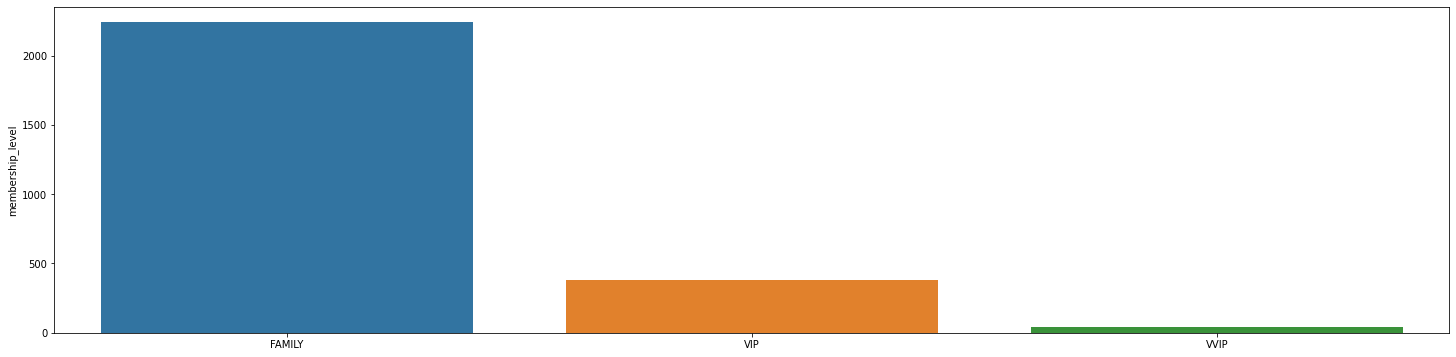

In [ ]:

# 시각화
figure = plt.figure(figsize=(25,6))
sns.barplot(x=df_data[condition]['membership_level'].value_counts().index, y=df_data[condition]['membership_level'].value_counts())

In [ ]:
df_data['membership_level'].value_counts()

FAMILY         18483
VIP            15668
VVIP           12106
공무원연금공단(폐쇄)      231
스탁직원              59
Family(패밀리)       38
Name: membership_level, dtype: int64

In [ ]:
df_data['brand'].value_counts()

래핑차일드       3706
마코 SALE     2650
밍크뮤         2468
럭스골프        2140
까스텔바작       2090
            ... 
베네스트           1
엘르[선글라스]       1
코리타홈쇼핑         1
아르떼_W몰         1
마스터베어          1
Name: brand, Length: 347, dtype: int64

In [ ]:
df_data['product_name'].value_counts()

럭스골프 초경량 프리미엄 구스다운 점퍼 LX2A801             421
이동수골프 남여 골프의류 긴팔 티셔츠 12종 택1               419
[PAT 남성]데님 라이크 팬츠_1E51603                 301
(공용) 푸조(FUZZO) 카치온 트레이닝복 세트_SG5U1TR134    256
(남성) WOOL KNIT ZIP 가디건_RM19SGD100         229
                                         ... 
(여성)면 혼방 속 허리 밴딩 워싱 데님 팬츠_MJW1DP01          1
(여성)언발 배색 반집업 티셔츠_MIW3TH62                  1
(제스) 울혼방 글렌체크 스트레치 팬츠 (X0ASP1202)           1
남성 울혼방 베이직 브이넥 니트 조끼 YD-VEW-460-블랙          1
KARRA 캐치포켓라인원피스+벨트SET_KB2FOP100A            1
Name: product_name, Length: 14203, dtype: int64

In [ ]:
df_data['address'].value_counts()

전북 전주시 완산구**********    515
경기 성남시 분당구**********    507
제주특별자치도 제주**********    435
경기 용인시 기흥구**********    424
경기 고양시 덕양구**********    420
                       ... 
서울 종로구 종로6**********      1
경기 의왕시 이미로**********      1
울산 동구 월봉7길**********      1
강원 춘천시 부평길**********      1
광주 동구 산수길3**********      1
Name: address, Length: 4703, dtype: int64

1. 성별에 대한 none값을 처리해주어야함 --> drop?
2. 나이안에 '-'값을 처리해주어야함 --> 각 등급별 나이의 평균값으로 대체 
3. 회원등급안에 같은 family인데 다르게 분류되어 있거나, 공무원 연금공단, 스탁직원 등 처리 --> family는 묶어주고 공무원연금공단과 스탁직원은 drop?
4. 성별을 수치화로 바꾸어줌(이진분류)
5. 상품명을 자연어 처리를 통해 간소화 해주어야함
6. 주소를 자연어 처리를 통해 도시명으로 나타내주어야함

### 1.성별 처리

In [ ]:
# 복제
pd_copy = df_data.copy()

In [ ]:
# 성별에 대한 것은 우선 drop을 해주자
criteria = df_data['sex'] != 'none'
df_data.loc[criteria,'sex'].value_counts()

여성    25092
남성    18673
Name: sex, dtype: int64

In [ ]:
# 2820개의 행이 날라감
df_data = df_data[criteria]
len(df_data)

43765

### 2.나이처리

In [ ]:
df_data['age'].dtype

dtype('O')

In [ ]:
# 나이가 1060으로 이상해
df_data['age'].value_counts()

-       2390
51      1882
52      1843
54      1746
50      1632
        ... 
83         2
16         2
1060       1
20         1
17         1
Name: age, Length: 76, dtype: int64

In [ ]:
# 우선 편리하게 진행하기 위해 -의 값을 제외한 나머지 나이는 int16으로 바꾸어 줍니다.
criteria = df_data.loc[:,'age'] != '-'
df_data.loc[:,'age'] = df_data.loc[criteria,'age'].astype(np.int16)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
df_data[df_data['age'].isna()].shape

(2390, 11)

In [ ]:
df_data['age'].sort_values(ascending = False)

35518    2022.0
35517    2022.0
33444    2022.0
33443    2022.0
1292     1060.0
          ...  
46514       NaN
46537       NaN
46576       NaN
46577       NaN
46578       NaN
Name: age, Length: 43765, dtype: float64

In [ ]:
df_data['age'] = df_data['age'].fillna(0)
df_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,membership_level,sex,age,sign_up_date,brand,product_name,total_price,purchase_price,order_date,address
0,hwa***,VVIP,여성,55.0,2016-06-16 09:32:15.860,아날도바시니,(아날도바시니) 리본타이 쉬폰 나염블라우스(AT03BL01M),53570,31000,2022-09-01 00:06:04.980,경남 진주시 초전동**********
1,hwa***,VVIP,여성,55.0,2016-06-16 09:32:15.860,예쎄,(예쎄) 스트라이프 카라 블라우스(YT09BL05A),53570,26600,2022-09-01 00:06:04.980,경남 진주시 초전동**********
2,dbs***,FAMILY,여성,0.0,2022-02-17 16:36:01.057,래핑차일드,(아동) 포인트 스웨트 팬츠_8712540250PK,35200,6300,2022-09-01 00:13:52.837,서울 관악구 문성로**********
3,dbs***,FAMILY,여성,0.0,2022-02-17 16:36:01.057,래핑차일드,(아동) 몬스터 배기 스웨트 팬츠_8712540202YE,35200,6300,2022-09-01 00:13:52.837,서울 관악구 문성로**********
4,dbs***,FAMILY,여성,0.0,2022-02-17 16:36:01.057,래핑차일드,(아동) 미키 롱티 원피스_8712950250IV,35200,7500,2022-09-01 00:13:52.837,서울 관악구 문성로**********


In [ ]:
# 나이가 - 인 것중에 family가 다수 vip와 vvip는 조금 있음
condition = df_data.age == 0
df_data[condition]['membership_level'].value_counts()

FAMILY    1991
VIP        359
VVIP        40
Name: membership_level, dtype: int64

In [ ]:
# 각 그룹별로 평균치를 찾습니다
criteria_1 = df_data.membership_level == 'FAMILY'
criteria_2 = df_data.membership_level == 'VIP'
criteria_3 = df_data.membership_level == 'VVIP'

criteria_4 = df_data.age != 0

criteria_final_1 = criteria_1 & criteria_4
criteria_final_2 = criteria_2 & criteria_4
criteria_final_3 = criteria_3 & criteria_4

In [ ]:
# 한번에 출력해서 보기
df_data[criteria_final_1]['age'].mean(),df_data[criteria_final_2]['age'].mean(),df_data[criteria_final_3]['age'].mean()

(46.475486819861, 52.14903846153846, 53.86240923477937)

In [ ]:
criteria_5 = df_data.age == 0
criteria_final_4 = criteria_1 & criteria_5
criteria_final_5 = criteria_2 & criteria_5
criteria_final_6 = criteria_3 & criteria_5
df_data.loc[criteria_final_4,'age'] = 46
df_data.loc[criteria_final_5,'age'] = 52
df_data.loc[criteria_final_6,'age'] = 54

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
# 값이 전부 바뀜
(df_data['age'] == 0).sum()

0

In [ ]:
# 이제 여기서 나이를 잘못 기입한 이상치를 찾아보자
# 100세이상일 경우 이상치로 간주
df_data[df_data['age'] > 100]

,id,membership_level,sex,age,sign_up_date,brand,product_name,total_price,purchase_price,order_date,address
1292,spe***,VVIP,여성,1060.0,2013-06-25 11:29:14.593,PAT [여성],[PAT 여성]스판 세미부츠컷 팬츠_QE61607,11700,13000,2022-09-01 16:44:44.457,인천 부평구 부개2**********
33443,jwj***,FAMILY,여성,2022.0,2022-08-26 17:02:34.510,블루독,(아동)하트 책가방_2897083313,27040,25000,2022-09-22 07:46:33.900,경기 광주시 오포읍**********
33444,jwj***,FAMILY,여성,2022.0,2022-08-26 17:02:34.510,블루독,(아동)하트 신주머니_2897083513,27040,8800,2022-09-22 07:46:33.900,경기 광주시 오포읍**********
35517,jwj***,FAMILY,여성,2022.0,2022-08-26 17:02:34.510,블루독,(아동)하트 신주머니_2897083513,27040,8800,2022-09-23 09:39:58.877,경기 광주시 오포읍**********
35518,jwj***,FAMILY,여성,2022.0,2022-08-26 17:02:34.510,블루독,(아동)하트 책가방_2897083313,27040,25000,2022-09-23 09:39:58.877,경기 광주시 오포읍**********


In [ ]:
df_data = df_data.drop(index=[1292,33443, 33444, 35517, 35518], axis=0)

In [ ]:
df_data.reset_index(inplace = True,drop = True)

In [ ]:
df_data[df_data['age'] > 100]

,id,membership_level,sex,age,sign_up_date,brand,product_name,total_price,purchase_price,order_date,address


### 3.회원등급 전처리

In [ ]:
pd_copy = df_data.copy()

In [ ]:
df_data['membership_level'].value_counts()

FAMILY         17958
VIP            14711
VVIP           10781
공무원연금공단(폐쇄)      214
스탁직원              58
Family(패밀리)       38
Name: membership_level, dtype: int64

In [ ]:
# Family(패밀리)를 FAMILY로 묶어주기
criteria = df_data['membership_level'] == 'Family(패밀리)'
df_data[criteria] = df_data[criteria].replace(['Family(패밀리)'], 'FAMILY')

In [ ]:
df_data['membership_level'].value_counts()

FAMILY         17996
VIP            14711
VVIP           10781
공무원연금공단(폐쇄)      214
스탁직원              58
Name: membership_level, dtype: int64

In [ ]:
# 공무원연금공단과 스탁직원 삭제
criteria_1 = df_data['membership_level'] != '공무원연금공단(폐쇄)'
criteria_2 = df_data['membership_level'] != '스탁직원'
final_criteria = criteria_1 & criteria_2
df_data = df_data[final_criteria]

In [ ]:
# 인덱스 초기화
df_data.reset_index

<bound method DataFrame.reset_index of            id membership_level sex   age            sign_up_date   brand  \
0      hwa***             VVIP  여성  55.0 2016-06-16 09:32:15.860  아날도바시니   
1      hwa***             VVIP  여성  55.0 2016-06-16 09:32:15.860      예쎄   
2      dbs***           FAMILY  여성  46.0 2022-02-17 16:36:01.057   래핑차일드   
3      dbs***           FAMILY  여성  46.0 2022-02-17 16:36:01.057   래핑차일드   
4      dbs***           FAMILY  여성  46.0 2022-02-17 16:36:01.057   래핑차일드   
...       ...              ...  ..   ...                     ...     ...   
43755  osl***           FAMILY  남성  47.0 2021-07-23 10:14:33.130    럭스골프   
43756  shm***           FAMILY  여성  38.0 2022-09-19 22:29:18.413      카라   
43757  shm***           FAMILY  여성  38.0 2022-09-19 22:29:18.413      카라   
43758  duc***           FAMILY  남성  51.0 2022-09-28 23:50:01.077    엘르골프   
43759  faj***           FAMILY  남성  44.0 2022-09-28 23:20:53.930    럭스골프   

                             product_name  total

In [ ]:
df_data.membership_level.value_counts()

FAMILY    17996
VIP       14711
VVIP      10781
Name: membership_level, dtype: int64

In [ ]:
df_data.head()

,id,membership_level,sex,age,sign_up_date,brand,product_name,total_price,purchase_price,order_date,address
0,hwa***,VVIP,여성,55.0,2016-06-16 09:32:15.860,아날도바시니,(아날도바시니) 리본타이 쉬폰 나염블라우스(AT03BL01M),53570,31000,2022-09-01 00:06:04.980,경남 진주시 초전동**********
1,hwa***,VVIP,여성,55.0,2016-06-16 09:32:15.860,예쎄,(예쎄) 스트라이프 카라 블라우스(YT09BL05A),53570,26600,2022-09-01 00:06:04.980,경남 진주시 초전동**********
2,dbs***,FAMILY,여성,46.0,2022-02-17 16:36:01.057,래핑차일드,(아동) 포인트 스웨트 팬츠_8712540250PK,35200,6300,2022-09-01 00:13:52.837,서울 관악구 문성로**********
3,dbs***,FAMILY,여성,46.0,2022-02-17 16:36:01.057,래핑차일드,(아동) 몬스터 배기 스웨트 팬츠_8712540202YE,35200,6300,2022-09-01 00:13:52.837,서울 관악구 문성로**********
4,dbs***,FAMILY,여성,46.0,2022-02-17 16:36:01.057,래핑차일드,(아동) 미키 롱티 원피스_8712950250IV,35200,7500,2022-09-01 00:13:52.837,서울 관악구 문성로**********


### 4.성별 이진분류

In [ ]:
df_sex = df_data['sex']
df_sex

0        여성
1        여성
2        여성
3        여성
4        여성
         ..
43755    남성
43756    여성
43757    여성
43758    남성
43759    남성
Name: sex, Length: 43488, dtype: object

In [ ]:
# 여성을 0, 남성을 1로 바꿔주기
for i in range(len(df_sex)) :
  if df_sex.iloc[i] == '여성':
    df_sex.iloc[i] = 0
  else:
    df_sex.iloc[i] = 1
df_sex

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0        0
1        0
2        0
3        0
4        0
        ..
43755    1
43756    0
43757    0
43758    1
43759    1
Name: sex, Length: 43488, dtype: object

In [ ]:
df_data['sex'] = df_sex

In [ ]:
df_data.reset_index(inplace = True,drop = True)

In [ ]:
# 이진분류 확인
df_data.sex.value_counts()

0    24967
1    18521
Name: sex, dtype: int64

### 5.상품명 처리

여기서 보면 
1. 문자열에서 어떻게 상품종류만 남길 것인가?
2. 원피스 + 벨트는 어떻게 해결할 것 인가
3. 깨진 문자열은 어떻게 할 것 인가? --> drop?
4. 분류를 리스트로 받을 것인가?

In [ ]:
 #인덱스 리셋
 df_data.reset_index(inplace = True,drop = True)

In [ ]:
pd_copy = df_data.copy()

In [ ]:
# # 첫 번째 시도
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_seq_items', None)
# pd.set_option('display.max_rows', None)
# pd_copy.loc[pd_copy.product_name.str.contains('블라우스'),'product_name']='블라우스'
# pd_copy.loc[pd_copy.product_name.str.contains('점퍼'),'product_name']='점퍼'
# pd_copy.loc[pd_copy.product_name.str.contains('티셔츠'),'product_name']='티셔츠'
# pd_copy.loc[pd_copy.product_name.str.contains('팬츠'),'product_name']='팬츠'
# pd_copy.loc[pd_copy.product_name.str.contains('가디건'),'product_name']='가디건'
# pd_copy.loc[pd_copy.product_name.str.contains('스커트'),'product_name']='스커트'
# pd_copy.loc[pd_copy.product_name.str.contains('수트'),'product_name']='수트'
# pd_copy.loc[pd_copy.product_name.str.contains('모자'),'product_name']='모자'
# pd_copy.loc[pd_copy.product_name.str.contains('니트'),'product_name']='니트'
# pd_copy.loc[pd_copy.product_name.str.contains('셔츠'),'product_name']='셔츠'
# pd_copy.loc[pd_copy.product_name.str.contains('벨트'),'product_name']='벨트'
# pd_copy.loc[pd_copy.product_name.str.contains('원피스'),'product_name']='원피스'
# pd_copy.loc[pd_copy.product_name.str.contains('드로즈'),'product_name']='드로즈'
# pd_copy.product_name.value_counts()

In [ ]:
# # 아이스탁몰을 보고 해당 카테고리명을 그대로 사용하였는지 확인
# # 골프 카테고리안 보호/연습용품이 있는지 확인
# for i in range(len(pd_copy)):
#     global a
#     a = '보호/연습용품' in pd_copy.iloc[i]['product_name']
# a = pd.Series(a)
# print(a.sum())

In [ ]:
df_data.loc[:,'product_classification'] = ''

In [ ]:
want_list = ['티셔츠','집업','하이넥','드로즈','베이스레이어','스웨트 티','브라팬티','백팩','운동화',
             '반팔티','긴팔티','셔켓','자켓','블레이져','조끼','수트','벨트','바지','집업','블라우스',
             '셔츠','니트','스웨터','가디건','원피스','투피스','코트','재킷','점퍼','팬츠',
             '스커트','아우터','정장','골프잡화','골프화','골프백','골프클럽','골프공','보호','연습용품',
             '등산화','배낭','가방','용품','장비','캠핑용품','세트','이지웨어','신발','패션소품','아동완구',
             '문구','유아용품','유아','쿠션지 포켓','오버롤','하프터틀','데님','골프장갑','양말','트렁크',
             '후디','덧신','삭스','레깅스','티셔츠','야상','풀오버','롱패딩','부츠','워킹화','제깅스','캡',
             '바람막이','팬티','우산','스니커즈','머플러','마스크','스타킹','이너웨어','KNIT','언더웨어',
             '헨리넥','KINT','큐롯','라이트 다운','래프 다운','푸퍼패딩','구스 다운','망토','가면','벙거지','숏패딩',
             '사각백','복주머니','스카프','요꼬에리','내피','맨투맨','보스턴백','로퍼','남방','헤어밴드','파우치백','반팔',
             '팔토시','장갑','반지갑','슬립온','큐롯','샌들','가운','신주머니','토트백','크로스백','쇼퍼백',
             '핫 팩','런닝화','래쉬가드','플리스','진','무스탕','구스다운','슬랙스','비니','슬링백','이너','미니백','브라탑',
             '블루종','후드','볼마커','런닝화','스트링백','트레킹화','상하복','슬리퍼','넥타이','장지갑','모자',
             '트레이닝 상의','트레이닝 하의','자켓','향수','브라','페도라','숄더백','구두']

In [ ]:
len(want_list)

149

In [ ]:
pd_copy

,id,membership_level,sex,age,sign_up_date,brand,product_name,total_price,purchase_price,order_date,address
0,hwa***,VVIP,0,55.0,2016-06-16 09:32:15.860,아날도바시니,(아날도바시니) 리본타이 쉬폰 나염블라우스(AT03BL01M),53570,31000,2022-09-01 00:06:04.980,경남 진주시 초전동**********
1,hwa***,VVIP,0,55.0,2016-06-16 09:32:15.860,예쎄,(예쎄) 스트라이프 카라 블라우스(YT09BL05A),53570,26600,2022-09-01 00:06:04.980,경남 진주시 초전동**********
2,dbs***,FAMILY,0,46.0,2022-02-17 16:36:01.057,래핑차일드,(아동) 포인트 스웨트 팬츠_8712540250PK,35200,6300,2022-09-01 00:13:52.837,서울 관악구 문성로**********
3,dbs***,FAMILY,0,46.0,2022-02-17 16:36:01.057,래핑차일드,(아동) 몬스터 배기 스웨트 팬츠_8712540202YE,35200,6300,2022-09-01 00:13:52.837,서울 관악구 문성로**********
4,dbs***,FAMILY,0,46.0,2022-02-17 16:36:01.057,래핑차일드,(아동) 미키 롱티 원피스_8712950250IV,35200,7500,2022-09-01 00:13:52.837,서울 관악구 문성로**********
...,...,...,...,...,...,...,...,...,...,...,...
43483,osl***,FAMILY,1,47.0,2021-07-23 10:14:33.130,럭스골프,이동수골프 남여 골프의류 긴팔 티셔츠 12종 택1,19800,6900,2022-09-28 23:50:40.677,경기 동두천시 지행**********
43484,shm***,FAMILY,0,38.0,2022-09-19 22:29:18.413,카라,KARRA 백밴딩롱데님원피스_KB2FOP061C,67040,35900,2022-09-28 23:51:07.680,경기 성남시 분당구**********
43485,shm***,FAMILY,0,38.0,2022-09-19 22:29:18.413,카라,KARRA 캐치포켓라인원피스+벨트SET_KB2FOP100A,67040,47900,2022-09-28 23:51:07.680,경기 성남시 분당구**********
43486,duc***,FAMILY,1,51.0,2022-09-28 23:50:01.077,엘르골프,(남성)사각무늬조직감폴로티셔츠_6F55208,23200,29000,2022-09-28 23:53:04.883,경남 김해시 율하1**********


In [ ]:
for n in range(len(df_data)):
  z = df_data.loc[n,'product_name']
  for m in range(len(want_list)):
    if want_list[m] in z:
      df_data.loc[n,'product_classification'] = want_list[m]

In [ ]:
df_data.isna().sum().sum()

1615

In [ ]:
df_data['product_classification'].value_counts()

티셔츠     6315
팬츠      4414
셔츠      2264
유아      2163
자켓      1927
        ... 
스트링백       3
향수         3
신발         3
투피스        1
배낭         1
Name: product_classification, Length: 128, dtype: int64

In [ ]:
# 카테고리화가 안된 것 확인
pd.set_option('display.max_rows', None)
df_data[df_data['product_classification'] == '' ]['product_name'].value_counts(ascending = False)

Series([], Name: product_name, dtype: int64)

In [ ]:
criteria = df_data['product_classification'] != ''
df_data = df_data[criteria]

In [ ]:
len(df_data)

43488

In [ ]:
df_data.product_classification.value_counts()

티셔츠        6315
팬츠         4414
셔츠         2264
유아         2163
자켓         1927
니트         1487
바지         1370
점퍼         1338
데님         1195
반팔         1174
원피스        1155
세트          980
후드          799
블라우스        778
집업          771
가디건         715
맨투맨         546
스웨트 티       528
스커트         493
모자          479
구스다운        455
오버롤         425
양말          418
큐롯          368
KNIT        364
레깅스         359
코트          350
상하복         327
브라          324
풀오버         319
부츠          304
스웨터         294
바람막이        282
베이스레이어      270
스니커즈        269
수트          258
캡           250
재킷          228
하이넥         213
블루종         202
벨트          188
언더웨어        182
슬랙스         179
진           176
스카프         163
플리스         161
이너          155
장갑          154
헨리넥         151
백팩          129
셔켓          127
삭스          123
운동화         120
정장          109
후디          107
슬립온          94
블레이져         89
머플러          87
조끼           85
넥타이          83
워킹화          81
구두           79
야상      

In [ ]:
pd.options.display.max_rows = 100
df_data.reset_index(inplace = True,drop = True)



*   KNIT -> 니트
*   삭스 -> 양말
*   재킷 -> 자켓
*   배낭 -> 가방
*   드로즈, 팬티 -> 언더웨어
*   KINT


In [ ]:
# 변경 전 확인
df_data[df_data.loc[:,'product_classification'] == 'KNIT']

,id,membership_level,sex,age,sign_up_date,brand,product_name,total_price,purchase_price,order_date,address,product_classification
152,nnf***,FAMILY,1,41.0,2022-08-31 15:41:27.230,루트A,(남성) WOOL KNIT ZIP 가디건_RM19SGD100,61660,14300,2022-09-01 06:34:11.247,경기 남양주시 다산**********,KNIT
293,pvc***,VIP,1,54.0,2018-04-04 08:52:09.017,루트A,(남성) WOOL KNIT ZIP 가디건_RM19SGD100,10010,14300,2022-09-01 09:27:05.277,충북 제천시 청풍호**********,KNIT
381,son***,VIP,1,56.0,2020-05-29 09:46:56.860,루트A,(남성) WOOL KNIT ZIP 가디건_RM19SGD100,10010,14300,2022-09-01 10:13:17.917,경남 창원시 의창구**********,KNIT
491,ram***,FAMILY,0,46.0,2022-09-01 10:58:03.623,밍크뮤,(유아) 자수 KNIT 원피스_37D1340202,119200,24000,2022-09-01 11:15:49.840,서울 동작구 상도로**********,KNIT
726,ist***,VIP,1,44.0,2015-04-26 10:24:11.350,루트A,(남성) WOOL KNIT ZIP 가디건_RM19SGD100,16030,14300,2022-09-01 12:44:10.357,경기도 화성시 융건**********,KNIT
...,...,...,...,...,...,...,...,...,...,...,...,...
42248,rin***,VIP,1,61.0,2016-09-01 15:19:38.887,루트A,(남성) WOOL KNIT ZIP 가디건_RM19SGD100,142430,13500,2022-09-28 11:28:20.860,경기 성남시 분당구**********,KNIT
42406,har***,VVIP,0,36.0,2021-12-10 10:53:12.527,블루독베이비,(유아) 펭귄KNIT 우주복 SET_47C1260201,66720,27000,2022-09-28 12:54:05.090,경기 부천시 역곡로**********,KNIT
43366,pro***,VVIP,1,33.0,2018-02-03 09:33:13.383,루트A,(남성) WOOL KNIT ZIP 가디건_RM19SGD100,18900,13500,2022-09-28 22:54:34.757,경기 고양시 덕양구**********,KNIT
43367,pro***,VVIP,1,33.0,2018-02-03 09:33:13.383,루트A,(남성) WOOL KNIT ZIP 가디건_RM19SGD100,18900,13500,2022-09-28 22:54:34.757,경기 고양시 덕양구**********,KNIT


In [ ]:
df_data.loc[df_data.loc[:,'product_classification'] == 'KNIT','product_classification'] = '니트'
df_data.loc[df_data.loc[:,'product_classification'] == '삭스','product_classification'] = '양말'
df_data.loc[df_data.loc[:,'product_classification'] == '재킷','product_classification'] = '자켓'
df_data.loc[df_data.loc[:,'product_classification'] == '배낭','product_classification'] = '가방'
df_data.loc[df_data.loc[:,'product_classification'] == '드로즈','product_classification'] = '언더웨어'
df_data.loc[df_data.loc[:,'product_classification'] == '팬티','product_classification'] = '언더웨어'

In [ ]:
df_data['product_classification'].value_counts()

티셔츠     6315
팬츠      4414
셔츠      2264
유아      2163
자켓      2155
        ... 
보호         5
스트링백       3
향수         3
신발         3
투피스        1
Name: product_classification, Length: 122, dtype: int64

In [ ]:
df_data[df_data.loc[:,'product_classification'] == None]
df_data.isna().sum()

id                           0
membership_level             0
sex                          0
age                          0
sign_up_date                 0
brand                        0
product_name                 0
total_price                  0
purchase_price               0
order_date                   0
address                      0
product_classification    1615
dtype: int64

In [ ]:
# 어떤 내용이 결측치로 표현 되었는지 확인
idx = df_data.product_classification.isna()
df_data[idx]

,id,membership_level,sex,age,sign_up_date,brand,product_name,total_price,purchase_price,order_date,address,product_classification
96,dhk***,VVIP,1,56.0,2018-06-29 14:46:21.240,두아니[패션잡화],[DUANI] 소프트 터치 남성화_MEMYSUZ9201,28710,31900,2022-09-01 03:01:25.360,대구 달서구 장기로**********,NaN
100,asd***,VIP,0,29.0,2022-03-19 23:54:49.723,에블린,[에블린] 변형 역삼각 백 레이스 끈(EBAF6A7012_19),38300,4900,2022-09-01 03:10:18.770,경기 김포시 구래동**********,NaN
101,asd***,VIP,0,29.0,2022-03-19 23:54:49.723,에블린,[에블린] 변형 버터플라이 백 디테일 끈(EBAF6A7013_19),38300,4900,2022-09-01 03:10:18.770,경기 김포시 구래동**********,NaN
102,asd***,VIP,0,29.0,2022-03-19 23:54:49.723,에블린,[에블린] 변형 레이스 날개 끈(EBAF6A7014_19),38300,4900,2022-09-01 03:10:18.770,경기 김포시 구래동**********,NaN
208,sup***,FAMILY,0,44.0,2022-04-03 07:26:14.477,밤비노,(공용)배색단가라티_ABF1UTS4010_GN,19900,19900,2022-09-01 08:11:17.890,경기 이천시 부발읍**********,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
43309,ljw***,VVIP,1,36.0,2016-01-05 13:41:40.437,NII,[NII] 공용 게임체인져 숏슬리브_NOUARWM5476,19320,5900,2022-09-28 22:43:58.160,서울 강서구 등촌로**********,NaN
43360,ilo***,VIP,0,39.0,2019-05-08 11:12:31.587,래핑차일드,(아동) 버드 포인트 스카쟌_87C1611050NY,29040,12000,2022-09-28 22:49:58.000,경기 화성시 동탄순**********,NaN
43407,bon***,VIP,1,51.0,2017-03-01 23:52:11.170,톨비스트,(남성)Spiral HEAT 다운 베스트_GA9W1-MVT510,75060,83400,2022-09-28 23:18:37.617,경남 밀양시 창밀로**********,NaN
43425,tar***,VIP,0,38.0,2018-10-22 20:18:57.370,래핑차일드,(아동) 마블 레터링 티_8812933151GR,50160,3800,2022-09-28 23:25:37.687,경기 하남시 위례대**********,NaN


In [ ]:
# 43488 - 1615 = 41873으로 데이터 개수가 바뀜
df_data = df_data.dropna(axis=0)
len(df_data)

41873

### 6.주소 슬라이싱

In [ ]:
df_data.reset_index(inplace = True,drop = True)
pd_copy = df_data.copy()

In [ ]:
df_data.address.value_counts()

전북 전주시 완산구**********    482
경기 성남시 분당구**********    461
제주특별자치도 제주**********    389
경기 용인시 기흥구**********    385
경기 고양시 덕양구**********    380
                       ... 
경기 의왕시 이미로**********      1
전남 보성군 벌교읍**********      1
경기 시흥시 연성로**********      1
강원 춘천시 부평길**********      1
광주 동구 산수길3**********      1
Name: address, Length: 4511, dtype: int64

In [ ]:
address = df_data.address

In [ ]:
for i in range(len(df_data.address)):
    x = address[i]
    df_data.address[i] = x[:-10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_data.address.isna().sum()

0

In [ ]:
df_data.address.value_counts()

전북 전주시 완산구    482
경기 성남시 분당구    461
제주특별자치도 제주    389
경기 용인시 기흥구    385
경기 고양시 덕양구    380
             ... 
경기 의왕시 이미로      1
전남 보성군 벌교읍      1
경기 시흥시 연성로      1
강원 춘천시 부평길      1
광주 동구 산수길3      1
Name: address, Length: 4511, dtype: int64

In [ ]:
pd.options.display.max_rows = 60

## 3-3. 메모리 용량 줄이기

In [ ]:
df_data.reset_index(inplace = True,drop = True)

In [ ]:
pd_copy = df_data.copy()

In [ ]:
original_mem = df_data.memory_usage(deep=True)
original_mem

Index                         128
id                        2637997
membership_level          3493189
sex                       1411732
age                        334984
sign_up_date               334984
brand                     4369045
product_name              8260299
total_price                334984
purchase_price             334984
order_date                 334984
address                   4270871
product_classification    3642626
dtype: int64

In [ ]:
# 데이터 용량 줄여주기
df_data.dtypes

id                                object
membership_level                  object
sex                               object
age                              float64
sign_up_date              datetime64[ns]
brand                             object
product_name                      object
total_price                        int64
purchase_price                     int64
order_date                datetime64[ns]
address                           object
product_classification            object
dtype: object

In [ ]:
df_data.describe()

,age,total_price,purchase_price
count,41873.000000,4.187300e+04,41873.000000
mean,50.062355,9.478488e+04,26191.570176
std,10.228454,2.581172e+05,24035.751286
min,14.000000,-5.778000e+04,600.000000
25%,43.000000,3.048000e+04,10900.000000
50%,51.000000,5.344000e+04,19900.000000
75%,57.000000,9.500000e+04,34200.000000
max,92.000000,3.942120e+06,999000.000000


In [ ]:
np.iinfo(np.int8)

iinfo(min=-128, max=127, dtype=int8)

In [ ]:
# int32로 변경
df_data['total_price'] = df_data['total_price'].astype(np.int32)
df_data['purchase_price'] = df_data['purchase_price'].astype(np.int32)

In [ ]:
df_data.select_dtypes(include=["object"]).nunique()

id                         5296
membership_level              3
sex                           2
brand                       321
product_name              12596
address                    4511
product_classification      122
dtype: int64

In [ ]:
df_data = df_data.astype({'membership_level':'category',
                          'sex':'category',
                          'brand': 'category',
                          'product_classification':'category',
                          'address':'category'
                          })

In [ ]:
new_mem = df_data.memory_usage(deep=True)
new_mem

Index                         128
id                        2637997
membership_level            42229
sex                         41997
age                        334984
sign_up_date               334984
brand                      126244
product_name              8260299
total_price                167492
purchase_price             167492
order_date                 334984
address                    795813
product_classification      57911
dtype: int64

In [ ]:
# 44.7% 용량이 줄어듬
new_mem.sum()/original_mem.sum() * 100

44.69823012527853

## 3-4. 전처리 데이터 저장

In [ ]:
df_data.to_excel('/content/drive/MyDrive/캡스톤 디자인/customer.xlsx') #csv파일로 생성

In [ ]:
# 저장 확인
d = pd.read_excel('/content/drive/MyDrive/캡스톤 디자인/customer.xlsx')

In [ ]:
d

,Unnamed: 0,id,membership_level,sex,age,sign_up_date,brand,product_name,total_price,purchase_price,order_date,address,product_classification
0,0,hwa***,VVIP,0,55,2016-06-16 09:32:15.860,아날도바시니,(아날도바시니) 리본타이 쉬폰 나염블라우스(AT03BL01M),53570,31000,2022-09-01 00:06:04.980,경남 진주시 초전동,블라우스
1,1,hwa***,VVIP,0,55,2016-06-16 09:32:15.860,예쎄,(예쎄) 스트라이프 카라 블라우스(YT09BL05A),53570,26600,2022-09-01 00:06:04.980,경남 진주시 초전동,블라우스
2,2,dbs***,FAMILY,0,46,2022-02-17 16:36:01.057,래핑차일드,(아동) 포인트 스웨트 팬츠_8712540250PK,35200,6300,2022-09-01 00:13:52.837,서울 관악구 문성로,팬츠
3,3,dbs***,FAMILY,0,46,2022-02-17 16:36:01.057,래핑차일드,(아동) 몬스터 배기 스웨트 팬츠_8712540202YE,35200,6300,2022-09-01 00:13:52.837,서울 관악구 문성로,팬츠
4,4,dbs***,FAMILY,0,46,2022-02-17 16:36:01.057,래핑차일드,(아동) 미키 롱티 원피스_8712950250IV,35200,7500,2022-09-01 00:13:52.837,서울 관악구 문성로,원피스
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41868,41868,osl***,FAMILY,1,47,2021-07-23 10:14:33.130,럭스골프,이동수골프 남여 골프의류 긴팔 티셔츠 12종 택1,19800,6900,2022-09-28 23:50:40.677,경기 동두천시 지행,티셔츠
41869,41869,shm***,FAMILY,0,38,2022-09-19 22:29:18.413,카라,KARRA 백밴딩롱데님원피스_KB2FOP061C,67040,35900,2022-09-28 23:51:07.680,경기 성남시 분당구,데님
41870,41870,shm***,FAMILY,0,38,2022-09-19 22:29:18.413,카라,KARRA 캐치포켓라인원피스+벨트SET_KB2FOP100A,67040,47900,2022-09-28 23:51:07.680,경기 성남시 분당구,원피스
41871,41871,duc***,FAMILY,1,51,2022-09-28 23:50:01.077,엘르골프,(남성)사각무늬조직감폴로티셔츠_6F55208,23200,29000,2022-09-28 23:53:04.883,경남 김해시 율하1,티셔츠


# 4-탐색적 데이터 분석

* k-nn> -> 되도록 수치형
* 쇼핑몰 신규고객 vip vvip성장 가능성 판단 (마케팅에 도움)
* 현재 vip, vvip 고객들이 어떤 구매 패턴을 보였는가
* 공통점, 차이점 -> 특성 분석

In [ ]:
df_data.reset_index(inplace = True,drop = True)
pd_copy = df_data.copy()

In [ ]:
pd_copy.brand.value_counts().head(10).index

CategoricalIndex(['래핑차일드', '마코 SALE', '밍크뮤', '럭스골프', '까스텔바작', '카파', '블루독베이비',
                  '루트A', 'JDX골프스포츠', '울시골프'],
                 categories=['BTR', 'BYC', 'CPX', 'DAN', 'EnC', 'EnC_W몰', 'FILA[신발]_LF스퀘어', 'GUESS_강변테크노', ...], ordered=False, dtype='category')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47792 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49888 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48156 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53272 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50612 missing from current font.
  font.set_

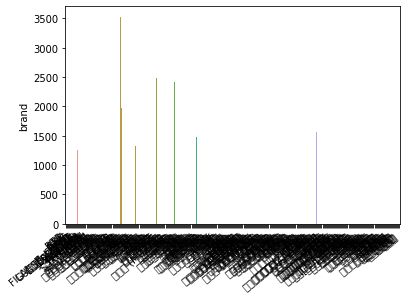

<Figure size 2160x1440 with 0 Axes>

In [ ]:
# 브랜드별 판매 수 확인하기
# 래핑차일드, 미코 SALE, 밍크류 순서로 판매가 가장 많이 됨
ax = sns.barplot(x=pd_copy.brand.value_counts().head(10).index, y=pd_copy.brand.value_counts().head(10))
figure = plt.figure(figsize=(30,20))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# 아이디와 브랜드를 묶어서 나누기
df_id_brand = df_data[['id','brand']]
df_id_brand.head()

,id,brand
0,hwa***,아날도바시니
1,hwa***,예쎄
2,dbs***,래핑차일드
3,dbs***,래핑차일드
4,dbs***,래핑차일드


In [ ]:
# 동일한 브랜드별로 샀는 사람들이 몇 명 있는지 확인
df_id_brand.groupby(by='brand', as_index=False).count().sort_values(by='id', ascending=False)

,brand,id
53,래핑차일드,3530
87,마코 SALE,2481
105,밍크뮤,2409
54,럭스골프,1973
33,까스텔바작,1955
...,...,...
115,베네스트,1
209,워모_W몰,1
247,케이스위스,1
94,몬자,1


In [ ]:
# 이용자별 브랜드 이용 수 확인해보기
df_id_brand.groupby(by='id', as_index=False).count().sort_values(by='brand', ascending=False)

,id,brand
2739,kim***,328
3024,lee***,278
2365,jin***,275
1017,cho***,274
3152,lov***,262
...,...,...
3346,mk5***,1
1376,dsa***,1
1373,ds4***,1
4420,smr***,1


# 5-연관 분석(유사도 분석)  

#### 5-1 라이브러리 설치

In [ ]:
import pandas as pd
import numpy as np

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline
rc('font', family='AppleGothic')

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/캡스톤 디자인/customer.xlsx')

In [ ]:
# 숫자와 문자 분리
df = df[['sex','age','total_price','purchase_price','id','membership_level','brand','product_classification','product_name','address','order_date','sign_up_date']]
df.head()

In [ ]:
# 모델에 넣기위한 파일 저장
df.to_excel('/content/drive/MyDrive/캡스톤 디자인/model_file.xlsx')

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/캡스톤 디자인/model_file.xlsx')

#### 5-2 가우어 유사도

In [ ]:
# 최대/최소 비율의 문제점 --> 이상치
# z-score로 정규화로 변경
# 가우어 유사도
def getMaxMin(f):
  max = []
  min = []
  parent = []
  max.append(f.max(axis=0))
  min.append(f.min(axis=0))
  for i in range(0,4): # 숫자 계산할 것
    parent.append(max[0][i] - min[0][i])
  return parent

def gower(file, parent):

  arr = np.array(file) #배열로 바꾸기     
  length_record = len(arr)      
  length_data = len(arr[0])    
    
  similarity = [[0]*length_record for i in range(length_record)] #2차원 배열 생성          
    
  for i in range(length_record-1):  # 고객 개수만큼         
    sim_data1 = arr[i]# 기준 데이터
    for j in range(i+1, length_record):
       #비교한것을              
      sum_data = 0
      sim_data2 = arr[j]
      for k in range(4): # 0 ~ 3번까지는 숫자계산                 
        sum_data += (abs(sim_data1[k] - sim_data2[k])/parent[k]) #확률을 모두 더하기 
      for k in range(4, length_data):
        if(eq(sim_data1[k], sim_data2[k])): #같으면 1 다르면 0
          sum_data += 1  
          similarity[i][j] = similarity[j][i] = sum_data/length_data                
  result = pd.DataFrame(similarity)    
  for i in range(len(result)):
    result[i][i] = 1 
  return result 

##### 1.유저 간의 유사도 계산

In [ ]:
file = pd.read_excel('/content/drive/MyDrive/캡스톤 디자인/model_file.xlsx')
file = file.iloc[:,1:]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [ ]:
# 1000명을 뽑아옴
f = file.iloc[:1000,:]
p = getMaxMin(f)

In [ ]:
p

In [ ]:
user_similarity = gower(f,p)
user_similarity

##### 2.유저들 중에서 유저i와 비슷한 유저 k명을 찾는다.

유저 '140'와 유사한 다른 유저 k명을 찾습니다.

In [ ]:
k = 5
user_i = 140
item_name = file.product_classification == '티셔츠'

In [ ]:
user_i_similarity = user_similarity.loc[user_i]
user_i_similarity

In [ ]:
user_i_similarity = user_i_similarity.sort_values(ascending=False)
user_i_similarity

유사도 상위 k명의 유사도와 id 추출합니다.

이때 가장 유사도가 높은 id는 user_i로 제외합니다.

In [ ]:
top_k_similarity = user_i_similarity[1:k+1]
top_k_similar_user_ids = top_k_similarity.index
top_k_similar_user_ids

In [ ]:
tok_k_similar_ratings = file.loc[top_k_similar_user_ids,'product_classification']
tok_k_similar_ratings

In [ ]:
top_k_weight = ()

#### 5-3 user-brand와의 연관

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/캡스톤 디자인/customer.xlsx')

In [ ]:
# 아이디별 브랜드 리스트를 만들어 묶고 구매 행렬 만들어 보기
mat = df.groupby('id')['brand'].apply(list).reset_index(name='brand')
mat_brand = mat.iloc[:,1]
mat_brand

0       [엘르골프, 팜스프링스, 팜스프링스, 톨비스트, 톨비스트, 캘빈클라인 언더웨어, 캘...
1                                            [카파, 카파, 카파]
2                                             [비버리힐스폴로클럽]
3       [PAT [남성], PAT [남성], 두아니[패션잡화], 데일리스트_20, 데일리스...
4                                [카파, 카파, 카파, 카파, 카파, 카파]
                              ...                        
5300                             [래핑차일드, 래핑차일드, 인디안, 인디안]
5301                       [NII, 루트A, 인터크루, 머렐, NII, NII]
5302                            [카라, 카라, 밤비노, 밤비노, 래핑차일드]
5303                                              [블루레이스]
5304                      [럭스골프, 밍크뮤, 밍크뮤, 밍크뮤, 밍크뮤, 밍크뮤]
Name: brand, Length: 5305, dtype: object

In [ ]:
mat

,id,brand
0,000***,"[엘르골프, 팜스프링스, 팜스프링스, 톨비스트, 톨비스트, 캘빈클라인 언더웨어, 캘..."
1,007***,"[카파, 카파, 카파]"
2,00c***,[비버리힐스폴로클럽]
3,00r***,"[PAT [남성], PAT [남성], 두아니[패션잡화], 데일리스트_20, 데일리스..."
4,00w***,"[카파, 카파, 카파, 카파, 카파, 카파]"
...,...,...
5300,zzo***,"[래핑차일드, 래핑차일드, 인디안, 인디안]"
5301,zzt***,"[NII, 루트A, 인터크루, 머렐, NII, NII]"
5302,zzu***,"[카라, 카라, 밤비노, 밤비노, 래핑차일드]"
5303,zzx***,[블루레이스]


In [ ]:
# 연관 분석을 위한 브랜드 카테고리별 서로 장바구니에 같이 담겼는지 확인
pd.set_option('display.max_columns',None)
te = TransactionEncoder()
te_ary = te.fit(mat_brand).transform(mat_brand)
matrix = pd.DataFrame(te_ary, columns=te.columns_) #위에서 나온걸 보기 좋게 데이터프레임으로 변경
matrix

,BTR,BYC,CPX,DAN,EnC,EnC_W몰,FILA[신발]_LF스퀘어,GUESS_강변테크노,GUESS_왕십리,HPE,J1JOA,JDX골프스포츠,KJSTYLE,NII,NIX_W몰,PAT [남성],PAT [여성],PBG골프,PRGR,RYN,S마켓_세이백화점,TBJ,TBJ_W몰,TMRW,TV쇼핑,yeoyoo[여성],게스키즈,게스키즈_LF스퀘어,귈림,그린조이,기어엑스(Gear X),김영주골프,까르뜨블랑슈,까스텔바작,까스텔바작_W몰,까스텔바작_세이백화점,꼬망스,넥센,노티카,니콜,더 파머,던롭,데니스골프,데일리스트,데일리스트_20,두아니 SS,두아니[패션잡화],듀퐁,디씨,디즈니골프,라코스테,라코스테 키즈,란체티_YM,래핑차일드,럭스골프,레노마골프,레노마골프_W몰,레노마셔츠_W몰,레노마수영복_세이백화점,레노마옴므_W몰,레드페이스,레코브,로또스포츠,로또스포츠 키즈,로베르따_W몰,루비루비,루이스골프,루트A,르까프,리바이스,리바이스_LF스퀘어,리바이스_W몰,리복,리복 언더웨어,리복키즈,리스트,리얼닥터,리카타,리트머스,리틀그라운드,마담4060,마담엘레강스,마레몬떼,마르조,마모트,마스터베어,마요,마코 SALE,망고스틴,매긴나잇브릿지,매일24365,머렐,모다까리나,모스트맘,몬자,몽벨,무자크 (MUZAK),미센스,미센스_SS,미스칸트,미스티카,미쏘언더웨어,미즈노_W몰,미즈노골프,밀레골프,밍크뮤,박홍근홈패션,반스,반에이크,반에이크_SS,반에이크오,밤비노,밸리걸_세이백화점,뱅뱅,버커루,베네스트,베니블루,보닌,본_W몰,본스텔라,브루노바피,브루노바피.,브리지스톤,블랙야크,블랙야크 키즈,블루독,블루독베이비,블루레이스,비너스_프라자,비버리힐스폴로클럽,비비안_프라자,비비올리비아,비비올리비아_20,비지트인뉴욕,비컴포트,비쿰,비트로,비티알_프라자,빌트모아,뿌야뿌,삐삐롱,샤트렌,샤트렌_W,샵앤,선덜랜드,세르지오_NCEX,세마,세바스찬골프,세인트나인,센터폴,셀마크 언더웨어,소다_W몰,수페르가,숲,쉔베르크,쉬즈미스,슈스파_W몰,슈페리어,스위트숲,스케쳐스,스테어,스파오(SPAO),스팍스,시스티나,아가방_LF스퀘어,아날도바시니,아놀드파마,아놀드파마_U,아다바트,아다바트화이트,아디다스 언더웨어,아디다스 키즈_세이백화점,아디다스(ADIDAS),아디다스_세이백화점,아디다스골프,아르떼_W몰,아베카,아이에이치밀라노,알로봇,알루에뜨,앙쥬,애드혹_W몰,앤드지 (ANDZ),앤드지_NC순천,에고이스트_W몰,에꼴드파리,에꼴드파리_SS,에디션 (EDITION),에블린,에스콰이아,에스티야긴,에이치커넥트,에코로바,엘르골프,엘르스포츠,엘르옴므,엠리밋,예쎄,예작_NC순천,올리반,올리비아로렌,올리비아로렌_20,올리비아하슬러,올리비아하슬러(여성),올리비아하슬러_W,올젠,올포유,옹알이마켓,울시골프,워모_W몰,원더브라_강변테크노,웨스트우드_프라자,웬디즈갤러리,윈덤,율미아스탭,이동수골프,이동수윌링,이스트웨스트,인디안,인디안.,인베스트,인터크루,인터크루_NC순천,인휴,일루션골프,임페리얼,잠뱅이_W몰,잭앤질,잭필드,제로골프,제스,제이로렌,제이폴락,지브이투어,지오지아 (ZIOZIA),지오지아_LF스퀘어,지이크파렌하이트_강변테크노,지프_W몰,체이스컬트_W몰,카라,카이아크만,카파,캘러웨이,캘빈클라인 언더웨어,캘빈클라인 퍼포먼스,커터앤벅,케리부룩[신발],케이스위스,코리타홈쇼핑,코모도 아이,콜핑,콜핑 키즈,퀵실버,크레송,크로커다일,크로커다일_NCEX,크로커다일레이디,크로커다일레이디(여성),크로커다일레이디_SS,크로커다일레이디_W,크리스찬딘,크리스크리스티,클라우스,클라이드_상봉,클럽코코아,클리브랜드,클리지 (CLIZY),키즈플렉스,타미지[제화]_세이백화점,타미힐피거,태창,탠디[제화]_세이백화점,테이트,테이트_W몰,테일러메이드,테일러메이드ACC,토마스베일리,토모톰스,톨비스트,톨비스트_SALE,톰스토리_W몰,투어골프,트레몰로,트레몰로.,트레비스골프,트루젠,트윈키즈,티아이포맨,티엔디,팀버랜드,파사디골프_W몰,파코라반베이비,파파브로,파파야,파파야_세이백화점,팜스프링스,팬텀_동아쇼핑,페라어스,페리힐즈,펜폴드,포커스,포커스[주얼리],푸마_상봉,푸마골프,푸마바디웨어,푸마스포츠,푸마키즈,프로스펙스,플라라,플래퍼,플러스에스큐,피에르가르뎅 [남성],해리슨,행텐_NC순천,허밍,헌트이너웨어,헤드 언더웨어,헤리토리골프,헨리메인,헨어스,홀릭앤플레이,힐크릭
0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
# 지지도(support): 전체 항목 중 x 와 y를 모두 포함하는 경우의 비율
frequent_itemsets = apriori(matrix, min_support=0.05, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.132893,(JDX골프스포츠)
1,0.098963,(PAT [남성])
2,0.054288,(PAT [여성])
3,0.170405,(까스텔바작)
4,0.078040,(데니스골프)
5,0.051084,(라코스테)
6,0.122337,(래핑차일드)
7,0.159849,(럭스골프)
8,0.097078,(루트A)
9,0.185485,(마코 SALE)


In [ ]:
# itemsets가 2개 이상인 것만 확인
frequent_itemsets.iloc[21:27,:]

,support,itemsets
21,0.051838,"(JDX골프스포츠, 마코 SALE)"
22,0.055796,"(마코 SALE, 까스텔바작)"
23,0.069746,"(래핑차일드, 밍크뮤)"
24,0.060509,"(블루독베이비, 래핑차일드)"
25,0.053157,"(마코 SALE, 럭스골프)"
26,0.078605,"(블루독베이비, 밍크뮤)"


In [ ]:
# antecedents: 조건절
# consequents: 결과절
# 신뢰도(confidence) : x가 있을 때 y도 있는 비율(조건부 비율)
# 향상도(lift) : 우연적 기회를 벗어나기 위한 값 .1이라면 우연적인 경우, x와 y의 관계가 독립이지만, 1보다 크거나 작다면 우연이 아닌 필연적인 관계에 있음
association_rules(frequent_itemsets, metric="lift", min_threshold=1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(JDX골프스포츠),(마코 SALE),0.132893,0.185485,0.051838,0.390071,2.102974,0.027188,1.335425
1,(마코 SALE),(JDX골프스포츠),0.185485,0.132893,0.051838,0.279472,2.102974,0.027188,1.203431
2,(마코 SALE),(까스텔바작),0.185485,0.170405,0.055796,0.300813,1.765280,0.024189,1.186513
3,(까스텔바작),(마코 SALE),0.170405,0.185485,0.055796,0.327434,1.765280,0.024189,1.211055
4,(래핑차일드),(밍크뮤),0.122337,0.124976,0.069746,0.570108,4.561723,0.054456,2.035449
5,(밍크뮤),(래핑차일드),0.124976,0.122337,0.069746,0.558069,4.561723,0.054456,1.985974
6,(블루독베이비),(래핑차일드),0.104807,0.122337,0.060509,0.577338,4.719228,0.047687,2.076512
7,(래핑차일드),(블루독베이비),0.122337,0.104807,0.060509,0.494607,4.719228,0.047687,1.771282
8,(마코 SALE),(럭스골프),0.185485,0.159849,0.053157,0.286585,1.792848,0.023508,1.177647
9,(럭스골프),(마코 SALE),0.159849,0.185485,0.053157,0.332547,1.792848,0.023508,1.220333


In [ ]:
# 향상도가 높은 것을 기준으로 나열해서 보기
association_rules(frequent_itemsets, metric="lift", min_threshold=1).sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
10,(밍크뮤),(블루독베이비),0.124976,0.104807,0.078605,0.628959,6.001131,0.065507,2.412655
11,(블루독베이비),(밍크뮤),0.104807,0.124976,0.078605,0.750000,6.001131,0.065507,3.500094
6,(블루독베이비),(래핑차일드),0.104807,0.122337,0.060509,0.577338,4.719228,0.047687,2.076512
7,(래핑차일드),(블루독베이비),0.122337,0.104807,0.060509,0.494607,4.719228,0.047687,1.771282
4,(밍크뮤),(래핑차일드),0.124976,0.122337,0.069746,0.558069,4.561723,0.054456,1.985974
5,(래핑차일드),(밍크뮤),0.122337,0.124976,0.069746,0.570108,4.561723,0.054456,2.035449
0,(마코 SALE),(JDX골프스포츠),0.185485,0.132893,0.051838,0.279472,2.102974,0.027188,1.203431
1,(JDX골프스포츠),(마코 SALE),0.132893,0.185485,0.051838,0.390071,2.102974,0.027188,1.335425
8,(럭스골프),(마코 SALE),0.159849,0.185485,0.053157,0.332547,1.792848,0.023508,1.220333
9,(마코 SALE),(럭스골프),0.185485,0.159849,0.053157,0.286585,1.792848,0.023508,1.177647


(블루독 베이비, 밍크뮤) / (블루독베이비, 래핑차일드)/ (래핑차일드, 밍크뮤)/ (까스텔바작, JDX골프스포츠)/ (마코 SALE, JDX스포츠)  
순서로 서로 연관되어 있는 것을 확인 할 수 있었습니다.

#### 5-4 user-item 연관

In [ ]:
# 아이디별 브랜드 리스트를 만들어 묶고 구매 행렬 만들어 보기
mat = df.groupby('brand')['product_classification'].apply(list).reset_index(name='product_classification')
mat_brand = mat.iloc[:,1]
mat_brand

,brand,product_classification
0,BTR,"[이너, 티, 티, 티, 티, 티, 반팔, 반팔, 반팔, 티, 티, 반팔, 티, 티..."
1,BYC,"[반팔, 반팔, 반팔, 반팔, 반팔, 반팔, 반팔, 반팔, 반팔, 반팔, 반팔, 언..."
2,CPX,"[바지, 바지, 바지, 점퍼, 티, 점퍼, 점퍼, 바지, 바지, 티, 티, 바지, ..."
3,DAN,"[스니커즈, 스니커즈]"
4,EnC,"[티, 블라우스]"
...,...,...
317,헤리토리골프,"[티, 자켓, 팬츠, 팬츠, 숄더백, 보스턴백, 보스턴백, 팬츠, 티, 바지, 팬츠..."
318,헨리메인,"[스니커즈, 스니커즈, 구두, 스니커즈, 스니커즈, 구두, 스니커즈, 슬립온, 니트..."
319,헨어스,"[후드, 점퍼, 점퍼, 야상, 야상, 데님, 데님, 야상, 야상, 자켓, 셔츠, 셔..."
320,홀릭앤플레이,[팬츠]


In [ ]:
# 연관 분석을 위한 브랜드 카테고리별 서로 장바구니에 같이 담겼는지 확인
pd.set_option('display.max_columns',None)
te = TransactionEncoder()
te_ary = te.fit(mat_brand).transform(mat_brand)
matrix = pd.DataFrame(te_ary, columns=te.columns_) #위에서 나온걸 보기 좋게 데이터프레임으로 변경
matrix

,KINT,가디건,가면,가방,가운,골프공,골프백,골프화,구두,구스 다운,구스다운,남방,내피,넥타이,니트,덧신,데님,등산화,라이트 다운,래쉬가드,래프 다운,런닝화,레깅스,로퍼,롱패딩,마스크,망토,맨투맨,머플러,모자,무스탕,미니백,바람막이,바지,반지갑,반팔,백팩,벙거지,베이스레이어,벨트,보스턴백,보호,복주머니,볼마커,부츠,브라,블라우스,블레이져,블루종,비니,사각백,상하복,샌들,세트,셔츠,셔켓,쇼퍼백,숄더백,숏패딩,수트,스니커즈,스웨터,스카프,스커트,스타킹,스트링백,슬랙스,슬리퍼,슬립온,슬링백,신발,신주머니,아우터,야상,양말,언더웨어,오버롤,요꼬에리,용품,우산,운동화,워킹화,원피스,유아,이너,자켓,장갑,장지갑,점퍼,정장,제깅스,조끼,진,집업,캡,코트,쿠션지 포켓,큐롯,크로스백,토트백,투피스,트렁크,트레이닝 상의,트레이닝 하의,트레킹화,티,파우치백,팔토시,팬츠,페도라,푸퍼패딩,풀오버,플리스,하이넥,하프터틀,향수,헤어밴드,헨리넥,후드,후디
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,Fal

In [ ]:
# 지지도(support): 전체 항목 중 x 와 y를 모두 포함하는 경우의 비율
frequent_itemsets = apriori(matrix, min_support=0.05, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.208075,(가디건)
1,0.055901,(구스다운)
2,0.288820,(니트)
3,0.217391,(데님)
4,0.108696,(레깅스)
...,...,...
6833,0.071429,"(점퍼, 반팔, 셔츠, 자켓, 티, 후드, 가디건, 니트, 팬츠)"
6834,0.052795,"(점퍼, 부츠, 셔츠, 자켓, 티, 후드, 가디건, 니트, 팬츠)"
6835,0.059006,"(데님, 반팔, 셔츠, 자켓, 티, 후드, 가디건, 점퍼, 팬츠)"
6836,0.055901,"(점퍼, 데님, 반팔, 셔츠, 자켓, 티, 후드, 니트, 팬츠)"


#### 5-5 brand-item 연관

# 6-군집분석

### 6-1 k-means++

#### 1.라이브러리 설치

In [ ]:
import pandas as pd
import numpy as np
from operator import eq 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline
rc('font', family='AppleGothic')

#### 2.군집분석

##### 1.데이터모델링

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/캡스톤 디자인/model_file.xlsx')

In [ ]:
df.head()

,Unnamed: 0,sex,age,total_price,purchase_price,id,membership_level,brand,product_classification,product_name,address,order_date,sign_up_date
0,0,0,55,53570,31000,hwa***,VVIP,아날도바시니,블라우스,(아날도바시니) 리본타이 쉬폰 나염블라우스(AT03BL01M),경남 진주시 초전동,2022-09-01 00:06:04.980,2016-06-16 09:32:15.860
1,1,0,55,53570,26600,hwa***,VVIP,예쎄,블라우스,(예쎄) 스트라이프 카라 블라우스(YT09BL05A),경남 진주시 초전동,2022-09-01 00:06:04.980,2016-06-16 09:32:15.860
2,2,0,46,35200,6300,dbs***,FAMILY,래핑차일드,팬츠,(아동) 포인트 스웨트 팬츠_8712540250PK,서울 관악구 문성로,2022-09-01 00:13:52.837,2022-02-17 16:36:01.057
3,3,0,46,35200,6300,dbs***,FAMILY,래핑차일드,팬츠,(아동) 몬스터 배기 스웨트 팬츠_8712540202YE,서울 관악구 문성로,2022-09-01 00:13:52.837,2022-02-17 16:36:01.057
4,4,0,46,35200,7500,dbs***,FAMILY,래핑차일드,원피스,(아동) 미키 롱티 원피스_8712950250IV,서울 관악구 문성로,2022-09-01 00:13:52.837,2022-02-17 16:36:01.057


In [ ]:
# 수치형만 떼어옴
df = df.iloc[:,1:5]

In [ ]:
df.head()

,sex,age,total_price,purchase_price
0,0,55,53570,31000
1,0,55,53570,26600
2,0,46,35200,6300
3,0,46,35200,6300
4,0,46,35200,7500


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df)
scaled = scaler.transform(df)
scaled
scaled_df = pd.DataFrame(scaled, columns=df.columns)

In [ ]:
scaled_df

,sex,age,total_price,purchase_price
0,0.0,0.525641,0.027838,0.030449
1,0.0,0.525641,0.027838,0.026042
2,0.0,0.410256,0.023246,0.005709
3,0.0,0.410256,0.023246,0.005709
4,0.0,0.410256,0.023246,0.006911
...,...,...,...,...
41868,1.0,0.423077,0.019395,0.006310
41869,0.0,0.307692,0.031206,0.035357
41870,0.0,0.307692,0.031206,0.047376
41871,1.0,0.474359,0.020246,0.028446


##### 2.모델 적용

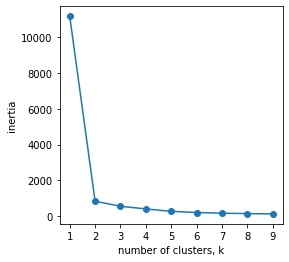

In [ ]:
from sklearn.cluster import KMeans
# 적절한 군집수 찾기
# Inertia(군집 내 거리제곱합의 합) value (적정 군집수)

ks = range(1,10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(scaled_df)
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.figure(figsize=(4, 4))

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


In [ ]:
# K-Means 모델과 군집 예측값을 생성

# 클러스터 모델 생성 파라미터는 원할 경우 추가
clust_model = KMeans(n_clusters = 3 # 클러스터 갯수
                     , n_init=10 # initial centroid를 몇번 샘플링한건지, 데이터가 많으면 많이 돌릴수록안정화된 결과가 나옴
                     , max_iter=500 # KMeans를 몇번 반복 수행할건지, K가 큰 경우 1000정도로 높여준다
                     , random_state = 42
#                      , algorithm='auto'
                    )

# 생성한 모델로 데이터를 학습시킴
clust_model.fit(scaled_df) # unsupervised learning 

# 결과 값을 변수에 저장
centers = clust_model.cluster_centers_ # 각 군집의 중심점
pred = clust_model.predict(scaled_df) # 각 예측군집

print(pd.DataFrame(centers))
print(pred[:10])

              0         1         2         3
0  1.000000e+00  0.516588  0.041314  0.028758
1 -2.126077e-14  0.536197  0.035324  0.026860
2 -2.153833e-14  0.319999  0.036151  0.020119
[1 1 2 2 2 2 2 0 0 0]


In [ ]:
# 원래 데이터에 예측된 군집 붙이기
clust_df = scaled_df.copy()
clust_df['clust'] = pred
clust_df.head()

,sex,age,total_price,purchase_price,clust
0,0.0,0.525641,0.027838,0.030449,1
1,0.0,0.525641,0.027838,0.026042,1
2,0.0,0.410256,0.023246,0.005709,2
3,0.0,0.410256,0.023246,0.005709,2
4,0.0,0.410256,0.023246,0.006911,2


In [ ]:
centers

array([[ 1.00000000e+00,  5.16588311e-01,  4.13141950e-02,
         2.87576615e-02],
       [-2.12607709e-14,  5.36196547e-01,  3.53239449e-02,
         2.68601615e-02],
       [-2.15383267e-14,  3.19999070e-01,  3.61513206e-02,
         2.01187676e-02]])

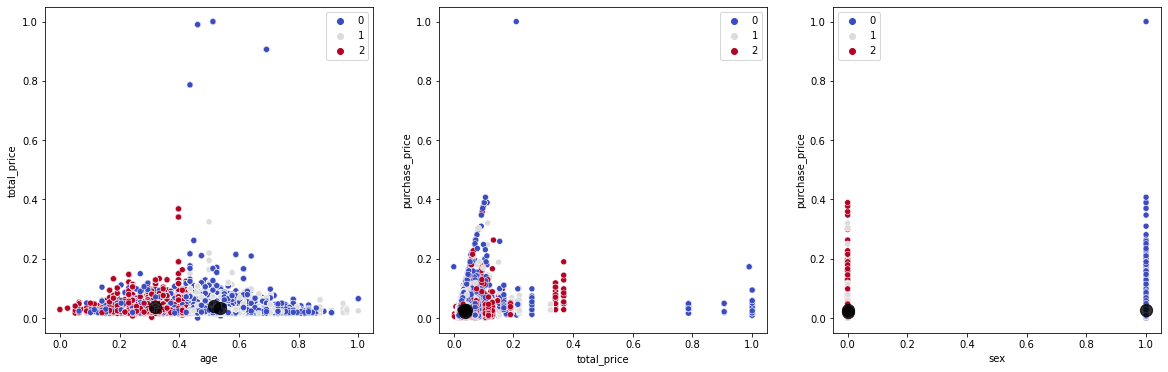

In [ ]:
# 시각화
plt.figure(figsize=(20, 6))

X = clust_df

plt.subplot(131)
sns.scatterplot(x=X.iloc[:,1], y=X.iloc[:,2], data=scaled_df, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,1], centers[:,2], c='black', alpha=0.8, s=150)

plt.subplot(132)
sns.scatterplot(x=X.iloc[:,2], y=X.iloc[:,3], data=scaled_df, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,2], centers[:,3], c='black', alpha=0.8, s=150)

plt.subplot(133)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,3], data=df, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,3], c='black', alpha=0.8, s=150)

plt.show()

### 6-2 k-modes

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline
rc('font', family='AppleGothic')

In [ ]:
!pip install kmodes
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt

* age, total_price, purchase_price scaling 작업 필요

###### 2.모델 적용

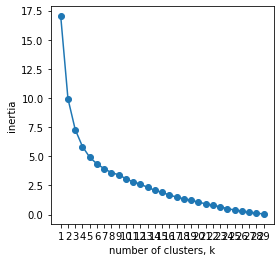

In [ ]:
from sklearn.cluster import KMeans
# 적절한 군집수 찾기
# Inertia(군집 내 거리제곱합의 합) value (적정 군집수)

ks = range(1,30)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k,
                   init = 'k-means++',
                   n_init=10,
                   max_iter=300,
                   random_state=0)
    model.fit(r)
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.figure(figsize=(4, 4))

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


In [ ]:
# K-Means 모델과 군집 예측값을 생성

# 클러스터 모델 생성 파라미터는 원할 경우 추가
clust_model = KMeans(n_clusters = 5
                     , init = 'k-means++'# 클러스터 갯수
                     , n_init = 20 # initial centroid를 몇번 샘플링한건지, 데이터가 많으면 많이 돌릴수록안정화된 결과가 나옴
                     , max_iter =300 # KMeans를 몇번 반복 수행할건지, K가 큰 경우 1000정도로 높여준다
                     , random_state = 42
                    #  , algorithm='auto'
                    )

# 생성한 모델로 데이터를 학습시킴
clust_model.fit(r) # unsupervised learning 

# 결과 값을 변수에 저장
centers = clust_model.cluster_centers_ # 각 군집의 중심점
pred = clust_model.predict(r) # 각 예측군집

print(pd.DataFrame(centers))
print(pred[:10])

             0             1         2         3         4         5   \
0  1.585275e-01  1.579014e-01  0.000000  0.000000  0.041383  0.041554   
1 -6.938894e-18 -6.938894e-18  0.223202  0.223202  0.238783  0.239075   
2  2.946007e-01  2.933485e-01  0.000000  0.000000  0.283364  0.284047   
3  0.000000e+00  0.000000e+00  0.000000  0.000000  0.000000  0.000000   
4  0.000000e+00  0.000000e+00  0.262558  0.262558  0.262217  0.262558   

         6             7             8             9   ...        20  \
0  0.000000  6.542860e-02  6.549975e-02  6.549975e-02  ...  0.000000   
1  0.214762  6.938894e-18  6.938894e-18  6.938894e-18  ...  0.192133   
2  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  ...  0.000000   
3  0.000000  2.892162e-01  2.892162e-01  2.892162e-01  ...  0.000000   
4  0.262217  0.000000e+00  0.000000e+00  0.000000e+00  ...  0.174653   

         21        22        23        24        25        26        27  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  

In [ ]:
# 원래 데이터에 예측된 군집 붙이기
clust_df = f.copy()
clust_df['clust'] = pred
clust_df.head()

,sex,age,total_price,purchase_price,membership_level,brand,product_classification,product_name,address,clust
0,0,55,53570,31000,VVIP,아날도바시니,블라우스,(아날도바시니) 리본타이 쉬폰 나염블라우스(AT03BL01M),경남 진주시 초전동,0
1,0,55,53570,26600,VVIP,예쎄,블라우스,(예쎄) 스트라이프 카라 블라우스(YT09BL05A),경남 진주시 초전동,0
2,0,46,35200,6300,FAMILY,래핑차일드,팬츠,(아동) 포인트 스웨트 팬츠_8712540250PK,서울 관악구 문성로,1
3,0,46,35200,6300,FAMILY,래핑차일드,팬츠,(아동) 몬스터 배기 스웨트 팬츠_8712540202YE,서울 관악구 문성로,1
4,0,46,35200,7500,FAMILY,래핑차일드,티,(아동) 미키 롱티 원피스_8712950250IV,서울 관악구 문성로,4


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50500 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45768 missing from current font.
  font.set_

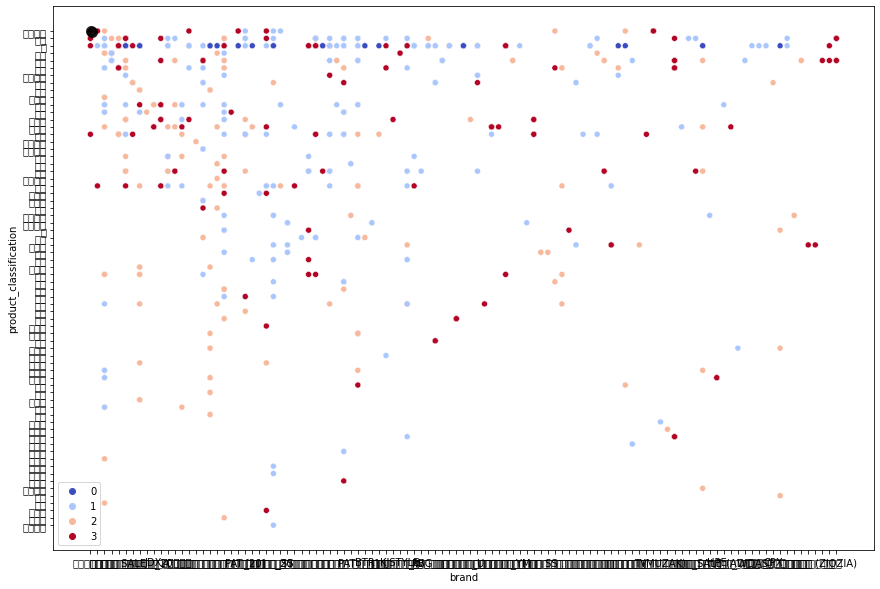

In [ ]:
plt.figure(figsize=(50, 10))

X = clust_df

plt.subplot(131)
sns.scatterplot(x=X.iloc[:,5], y=X.iloc[:,6], data=f, hue=clust_model.labels_, palette='coolwarm')
plt.scatter(centers[:,0], centers[:,6], c='black', alpha=0.5, s=100)

# plt.subplot(132)
# sns.scatterplot(x=X.iloc[:,1], y=X.iloc[:,2], data=r, hue=clust_model.labels_, palette='coolwarm')
# plt.scatter(centers[:,0], centers[:,2], c='black', alpha=0.8, s=150)

# plt.subplot(133)
# sns.scatterplot(x=X.iloc[:,1], y=X.iloc[:,3], data=r, hue=clust_model.labels_, palette='coolwarm')
# plt.scatter(?centers[:,0], centers[:,3], c='black', alpha=0.8, s=150)

plt.show()

#7-데이터의 한계점
  1. 아이디 비식별화로인한 유사도 측정의 한계
  
  (다른 사람이지만 비식별화로 인해 같은 사람의 아이디로 보임) 
  
  2. 평가 점수/ 리뷰평이 없어 유사도에 가중치를 주지 못합니다.

In [ ]:
len(file.loc[file.id == 'dbs***',:])

In [ ]:
# 그렇다면 total_price와 아이디가 같은 사람은 같은 사람이라고 볼 수 있을까?
y = file.groupby(['id','total_price'])['purchase_price'].agg('count')
# y.loc['hwa***',:]
y

id      total_price
000***  382430         10
007***  22950           3
00c***  27900           1
00r***  23220           2
        23400           2
                       ..
zzu***  25260           2
        49800           3
zzx***  35900           1
zzz***  24900           1
        79600           5
Name: purchase_price, Length: 18855, dtype: int64